In [1]:
from deepface import DeepFace
import cv2
import numpy as np
import pandas as pd
import csv, os, re, time, logging, cv2, torch
from pathlib import Path
from importlib.metadata import version
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
from moviepy.editor import VideoFileClip

ValueError: You have tensorflow 2.18.0 and this requires tf-keras package. Please run `pip install tf-keras` or downgrade your tensorflow.

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split
import os

In [3]:
input_files = sorted(
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_input.csv') + 
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_input.csv') + 
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_input.csv')
    )
label_files = sorted(
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS.csv') +
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_BORIS.csv') +
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_BORIS.csv')
    )

# First pass to calculate global mean and std


In [17]:
def get_train_test_splitted_data(label_files, input_files, global_mean, global_std, test_size=0.2, random_state=42):
    # Initialize lists to hold all sequences
    all_x_sequences = []
    all_y_sequences = []

    # Process each pair of input and label files
    for input_file, label_file in zip(input_files, label_files):
        # Load data
        input_df = pd.read_csv(input_file)
        label_df = pd.read_csv(label_file)

        # Prepare features and labels
        features = (input_df.values - global_mean) / global_std
        labels = label_df.values / 100

        # Ensure alignment of frames
        if features.shape[0] != labels.shape[0]:
            print(f"Mismatch in frames: {input_file}, {label_file}")
            continue

        # Sample sequences
        x_sequences, y_sequences = create_sequences(features, labels, SEQUENCE_LENGTH, STRIDE)

        # Append to global lists
        all_x_sequences.append(x_sequences)
        all_y_sequences.append(y_sequences)

    # Concatenate all sequences from all files
    all_x_sequences = np.concatenate(all_x_sequences, axis=0)
    all_y_sequences = np.concatenate(all_y_sequences, axis=0)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        all_x_sequences, all_y_sequences, test_size=test_size, random_state=random_state
    )

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Shuffle, batch, and prefetch
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    return train_dataset, test_dataset

In [18]:
# Constants
SEQUENCE_LENGTH = 10
STRIDE = 5
BATCH_SIZE = 32

# Helper function to create random sequences
def create_sequences(features, labels, sequence_length, stride):
    x_sequences, y_sequences = [], []
    for i in range(0, len(features) - sequence_length + 1, stride):
        x_sequences.append(features[i:i + sequence_length])
        y_sequences.append(labels[i:i + sequence_length])
    return np.array(x_sequences), np.array(y_sequences)

# Initialize lists to hold all sequences
all_x_sequences = []
all_y_sequences = []
all_features = []

sources = ["GUT", "ITU-YU", "MAAP"]
base_path = "//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/"
input_files, label_files = [], []

for source in sources:
    input_files.extend(glob.glob(os.path.join(base_path, source, '*_input.csv')))
    label_files.extend(glob.glob(os.path.join(base_path, source, '*_BORIS.csv')))

input_files.sort()
label_files.sort()


for input_file in input_files:
    input_df = pd.read_csv(input_file)
    all_features.append(input_df.values)

# Concatenate all features from all files to compute global mean and std
all_features = np.concatenate(all_features, axis=0)
global_mean = all_features.mean(axis=0)
global_std = all_features.std(axis=0)

# Ensure no division by zero
global_std[global_std == 0] = 1

GUT_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_input.csv'))
ITU_YU_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_input.csv'))
MAAP_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_input.csv'))

GUT_path_label = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS.csv'))
ITU_YU_path_label = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_BORIS.csv'))
MAAP_path_label = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_BORIS.csv'))

GUT_train, GUT_test = get_train_test_splitted_data(GUT_path_label, GUT_path_input, global_mean, global_std, test_size=0.3)
ITU_YU_train, ITU_YU_test = get_train_test_splitted_data(ITU_YU_path_label, ITU_YU_path_input, global_mean, global_std, test_size=0.3)
MAAP_train, MAAP_test = get_train_test_splitted_data(MAAP_path_label, MAAP_path_input, global_mean, global_std, test_size=0.3)

dataset = GUT_train.concatenate(ITU_YU_train).concatenate(MAAP_train)

# Verify the dataset
for x_batch, y_batch in dataset.take(1):
    print(f'Feature batch shape: {x_batch.shape}')
    print(f'Label batch shape: {y_batch.shape}')


Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)


In [49]:
path = r'Z:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'
tf.data.experimental.save(dataset ,os.path.join(path, 'train_dataset'))
tf.data.experimental.save(GUT_train, os.path.join(path, 'GUT_train'))
tf.data.experimental.save(GUT_test, os.path.join(path, 'GUT_test'))
tf.data.experimental.save(ITU_YU_train, os.path.join(path, 'ITU_YU_train'))
tf.data.experimental.save(ITU_YU_test, os.path.join(path, 'ITU_YU_test'))
tf.data.experimental.save(MAAP_train, os.path.join(path, 'MAAP_train'))
tf.data.experimental.save(MAAP_test, os.path.join(path, 'MAAP_test'))

In [8]:
dataset.cardinality().numpy()

320

In [19]:
for x_batch, y_batch in dataset.take(30):
    print(f'Feature batch shape: {x_batch.shape}')
    print(f'Label batch shape: {y_batch.shape}')

Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature ba

In [51]:
INPUT_DIM = 515  # Number of features per frame (e.g., biosignals + embeddings)
OUTPUT_DIM = 6 

In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQUENCE_LENGTH, INPUT_DIM)),    # Input shape: (sequence_length, features)
    tf.keras.layers.LSTM(64, return_sequences=True),              # LSTM layer to capture temporal patterns
    tf.keras.layers.Dense(32, activation='relu'),                 # Dense layer to reduce dimensionality
    tf.keras.layers.Dense(OUTPUT_DIM, activation='sigmoid')       # Output layer with sigmoid for continuous values between 0 and 1
])

In [53]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [54]:
history = model.fit(dataset, epochs=50)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0922 - mae: 0.2263
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0359 - mae: 0.0771
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0339 - mae: 0.0707
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0324 - mae: 0.0672
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0314 - mae: 0.0639
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0301 - mae: 0.0625
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0291 - mae: 0.0615
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0284 - mae: 0.0590
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0279 - mae: 0.0579
Epoch 10/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0272 - mae: 0.0560
Epoch 11/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0265 - mae: 0.0537
Epoch 12/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0261 - mae: 0.0530
Epoch 13/50
225/225 ━━━━━

In [55]:
# Make predictions for a few batches
for x_batch, y_batch in GUT_test:  # Take 3 batches as an example
    predictions = model.predict(x_batch)

    print("\nPredicted values:")
    print(predictions[:5])  # Show predictions for the first 5 sequences in the batch
    
    print("\nActual values:")
    print(y_batch.numpy()[:5])  # Show actual values for the first 5 sequences in the batch

    # Break after showing 3 batches
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step

Predicted values:
[[[3.94352386e-03 1.34392798e-01 1.40392901e-02 6.03646599e-03
   1.52632063e-02 1.92120497e-03]
  [4.02279850e-03 8.82497355e-02 8.08634236e-03 3.31659913e-02
   1.37109328e-02 1.71824591e-03]
  [1.25223669e-04 1.35691628e-01 1.74635220e-02 2.03310736e-02
   3.61985015e-03 2.43393052e-03]
  [2.44009942e-02 6.13778055e-01 2.17348803e-03 4.03376706e-02
   4.79427399e-03 2.47836672e-03]
  [1.63590461e-02 2.48925284e-01 2.33849557e-03 1.84787698e-02
   4.95931366e-03 9.57985059e-04]
  [2.05124356e-03 2.68029660e-01 2.78116250e-03 1.62254460e-02
   7.86195975e-03 2.31883535e-03]
  [2.57170759e-03 3.96721857e-03 9.40022699e-04 7.54383858e-03
   9.37459432e-03 7.80111644e-04]
  [7.87315774e-04 7.95203540e-03 1.86275283e-03 5.68171823e-03
   6.80484530e-03 1.14375236e-03]
  [1.03439891e-03 6.16254769e-02 1.83557032e-03 4.49236436e-03
   4.04601125e-03 5.38329710e-04]
  [3.06354580e-03 5.86372204e-02 1.57044595e-03 4.06839419e-03
   3.6

In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,276 (1.73 MB)

 Trainable params: 150,758 (588.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 301,518 (1.15 MB)

In [67]:
GUT_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 515), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10, 6), dtype=tf.float64, name=None))>

In [72]:
# Evaluate the model
loss, acc = model.evaluate(MAAP_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * (1-acc)))

72/72 - 0s - 3ms/step - loss: 0.0355 - mae: 0.0604
Untrained model, accuracy: 93.96%


In [66]:
model.save(os.path.join(path, 'saved_model/model.keras'))

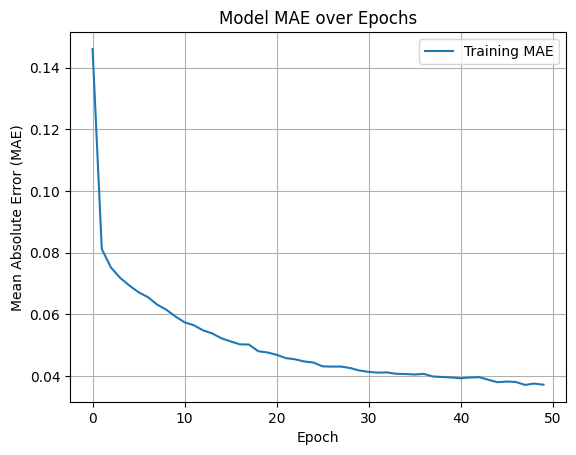

In [57]:
import matplotlib.pyplot as plt

# After training, 'history' holds the metrics for each epoch
# Plot MAE from the training history

# Access 'mae' values for each epoch
mae = history.history['mae']  # MAE for training data
# If you had validation data, access validation MAE as well
# val_mae = history.history['val_mae']

# Plot training MAE
plt.plot(mae, label='Training MAE')
# Uncomment below if you have validation data to compare
# plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model MAE over Epochs')
plt.legend()
plt.grid()
plt.show()
